In [6]:
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers
from sklearn.model_selection import train_test_split

## Finite Difference - Convection equation with Diffusion in 1D

In [2]:
x_left = -2
x_right = 2
t_end = 2

D = 0.02
v = 0.1
dx = 0.01
dt = 0.001

cfl = D*dt/dx**2
print('CFL = %.4f'%(cfl))
x_steps = int((x_right - x_left)/dx)
t_steps = int(t_end/dt)

xx = np.linspace(x_left, x_right, x_steps)
tt = np.linspace(0, t_end, t_steps)
uu = np.zeros((t_steps, x_steps))

CFL = 0.2000


In [3]:
# ICs 
def gaussian(x, mu, sig, shift):
    return shift + np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

ic_mean = 0
ic_std = 0.2
ic_shift = 0
uu[0, :] = gaussian(xx, ic_mean, ic_std, ic_shift)

In [4]:
# Euler Stepper
def adv_diff_euler_step(ul, uc, ur, D, v, dx, dt):
    return uc + D * dt/dx**2 * (ul - 2 * uc + ur) + v * dt/(2*dx) * (ur - ul)

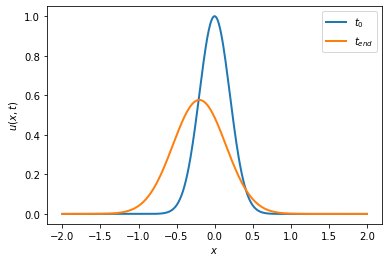

In [5]:
# Solve
inputs = []
outputs = []
for ti, t in enumerate(tt[:-1]):
    for xi, x in enumerate(xx[1:-1]):
        uu[ti+1, xi] = adv_diff_euler_step(uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1], D, v, dx, dt)

        # zero flux BC
        uu[ti+1, 0] = uu[ti+1, 1]
        uu[ti+1, -1] = uu[ti+1, -2]

        # Save data
        inputs.append([t, x])
        outputs.append(uu[ti+1, xi])

fig = plt.figure()
plt.plot(xx, uu[0, :], lw=2)
plt.plot(xx, uu[-1, :], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend(['$t_0$', '$t_{end}$'])


plt.show()

## Training a Dense Network

Epoch 1/10
14918/14918 [==============================] - 10s 685us/step - loss: 0.0129 - val_loss: 2.8657e-04
Epoch 2/10
14918/14918 [==============================] - 10s 647us/step - loss: 8.3885e-05 - val_loss: 1.9223e-04
Epoch 3/10
14918/14918 [==============================] - 10s 653us/step - loss: 5.0239e-05 - val_loss: 1.9758e-04
Epoch 4/10
14918/14918 [==============================] - 10s 647us/step - loss: 3.8029e-05 - val_loss: 9.8307e-05
Epoch 5/10
14918/14918 [==============================] - 11s 739us/step - loss: 3.0233e-05 - val_loss: 1.0750e-04
Epoch 6/10
14918/14918 [==============================] - 11s 713us/step - loss: 2.7560e-05 - val_loss: 1.0227e-04
Epoch 7/10
14918/14918 [==============================] - 10s 704us/step - loss: 2.5718e-05 - val_loss: 7.9388e-05
Epoch 8/10
14918/14918 [==============================] - 10s 651us/step - loss: 2.2560e-05 - val_loss: 8.7543e-05
Epoch 9/10
14918/14918 [==============================] - 9s 633us/step - loss: 2.15

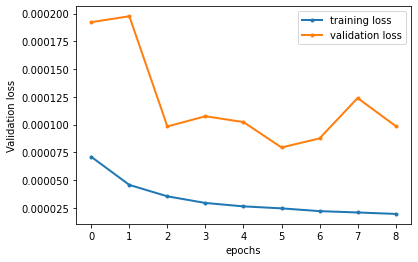

In [6]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(10, input_dim=2, activation='elu'))
deep_approx.add(layers.Dense(10, activation='elu'))
deep_approx.add(layers.Dense(1, activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_approx.fit(X_train, y_train,
            epochs=10, batch_size=32,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

deep_approx.summary()

# history.history contains loss information

idx0 = 1
plt.figure()
plt.plot(history.history['loss'][idx0:], '.-', lw=2)
plt.plot(history.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

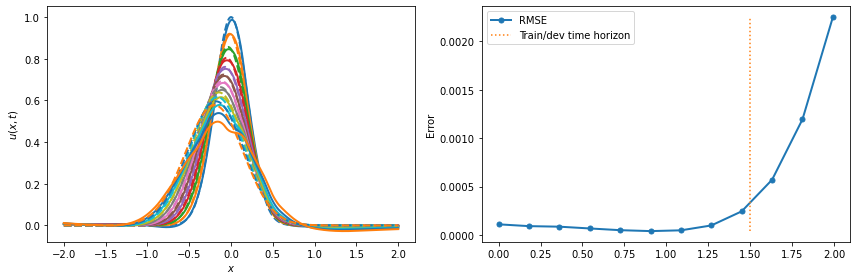

In [7]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

## Convolutional Neural Network - 1

In [8]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

In [10]:
#Reshaping is required for CNNs
X_train = X_train.reshape(-1,2,1,1)
X_dev = X_dev.reshape(-1,2,1,1)

In [12]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D

In [13]:
#CNN 1 model
deep_approx3 = Sequential()
deep_approx3.add(Conv2D(5, kernel_size=(1,1), activation='relu', input_shape=(2,1,1),padding='same'))
deep_approx3.add(Flatten())
deep_approx3.add(layers.Dense(20, activation='relu'))
deep_approx3.add(layers.Dense(1, activation='linear'))

deep_approx3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 1, 5)           10        
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [14]:
deep_approx3.compile(loss='mse', optimizer='adam')

In [15]:
history3 = deep_approx3.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
95472/95472 [==============================] - 67s 700us/step - loss: 0.0017 - val_loss: 1.5581e-04
Epoch 2/10
95472/95472 [==============================] - 65s 683us/step - loss: 5.7126e-05 - val_loss: 7.5553e-05
Epoch 3/10
95472/95472 [==============================] - 66s 694us/step - loss: 3.8716e-05 - val_loss: 6.7544e-05
Epoch 4/10
95472/95472 [==============================] - 62s 651us/step - loss: 3.3972e-05 - val_loss: 1.0839e-04
Epoch 5/10
95472/95472 [==============================] - 61s 637us/step - loss: 3.2158e-05 - val_loss: 5.8251e-05
Epoch 6/10
95472/95472 [==============================] - 62s 648us/step - loss: 2.9098e-05 - val_loss: 6.8717e-05
Epoch 7/10
95472/95472 [==============================] - 61s 637us/step - loss: 2.7557e-05 - val_loss: 3.6807e-05
Epoch 8/10
95472/95472 [==============================] - 61s 635us/step - loss: 2.5714e-05 - val_loss: 4.9722e-05
Epoch 9/10
95472/95472 [==============================] - 59s 621us/step - loss: 2.2

In [16]:
X_test = X_test.reshape(-1,2,1,1)

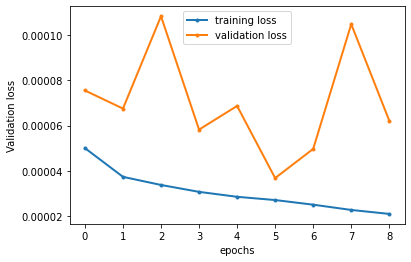

In [17]:
idx0 = 1
plt.figure()
plt.plot(history3.history['loss'][idx0:], '.-', lw=2)
plt.plot(history3.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

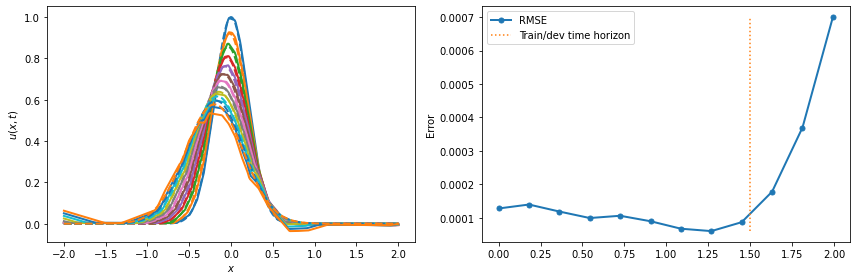

In [18]:
# This is the same code as before
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,2,1,1)#reshaping is required
    u_approx = deep_approx3.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

## CNN - 2

In [19]:
deep_approx4 = Sequential()
deep_approx4.add(Conv2D(20, kernel_size=(1,1), activation='relu', input_shape=(2,1,1),padding='same'))
deep_approx4.add(Flatten())
deep_approx4.add(layers.Dense(20, activation='relu'))
deep_approx4.add(layers.Dense(1, activation='linear'))

deep_approx4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 1, 20)          40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [21]:
deep_approx4.compile(loss='mse', optimizer='adam')
history4 = deep_approx4.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
95472/95472 [==============================] - 64s 671us/step - loss: 9.4091e-04 - val_loss: 7.9574e-05
Epoch 2/10
95472/95472 [==============================] - 61s 634us/step - loss: 3.0817e-05 - val_loss: 1.4215e-04
Epoch 3/10
95472/95472 [==============================] - 59s 615us/step - loss: 2.5436e-05 - val_loss: 1.0292e-04
Epoch 4/10
95472/95472 [==============================] - 65s 681us/step - loss: 2.2055e-05 - val_loss: 1.3491e-04
Epoch 5/10
95472/95472 [==============================] - 83s 868us/step - loss: 1.9958e-05 - val_loss: 7.0213e-05
Epoch 6/10
95472/95472 [==============================] - 76s 793us/step - loss: 1.8737e-05 - val_loss: 6.7146e-05
Epoch 7/10
95472/95472 [==============================] - 72s 751us/step - loss: 1.8393e-05 - val_loss: 6.2637e-05
Epoch 8/10
95472/95472 [==============================] - 79s 823us/step - loss: 1.8129e-05 - val_loss: 9.1392e-05
Epoch 9/10
95472/95472 [==============================] - 70s 731us/step - loss:

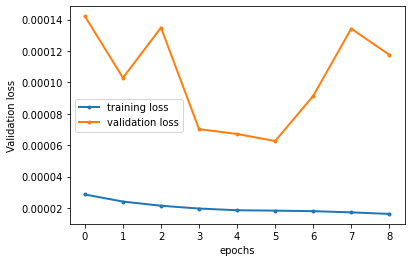

In [22]:
idx0 = 1
plt.figure()
plt.plot(history4.history['loss'][idx0:], '.-', lw=2)
plt.plot(history4.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

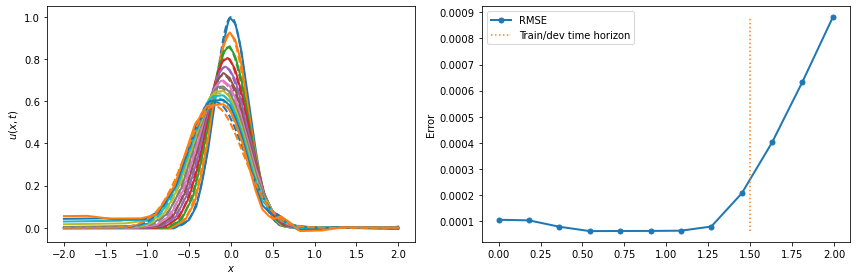

In [23]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,2,1,1)# reshaping is required
    u_approx = deep_approx4.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

## LSTM - Long Short Term Memory (Simple RNN)

In [24]:
#Again reshaping is required
X_train = X_train.reshape(-1,1,2)
X_dev = X_dev.reshape(-1,1,2)

In [25]:
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.models import Sequential

n_steps = 1
n_features = 2

deep_approx5 = Sequential()
deep_approx5.add(LSTM(15, activation='relu', input_shape=(n_steps, n_features)))
deep_approx5.add(layers.Dense(5, activation='relu'))
deep_approx5.add(layers.Dense(1, activation='linear'))

deep_approx5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1080      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 1,166
Trainable params: 1,166
Non-trainable params: 0
_________________________________________________________________


In [26]:
deep_approx5.compile(optimizer='adam', loss='mse')

In [27]:
history5 = deep_approx5.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
95472/95472 [==============================] - 117s 1ms/step - loss: 0.0019 - val_loss: 4.0954e-05
Epoch 2/10
95472/95472 [==============================] - 97s 1ms/step - loss: 2.5583e-05 - val_loss: 1.1631e-04
Epoch 3/10
95472/95472 [==============================] - 102s 1ms/step - loss: 1.6356e-05 - val_loss: 5.5189e-05
Epoch 4/10
95472/95472 [==============================] - 103s 1ms/step - loss: 1.1361e-05 - val_loss: 1.3923e-05
Epoch 5/10
95472/95472 [==============================] - 102s 1ms/step - loss: 8.6279e-06 - val_loss: 1.2283e-05
Epoch 6/10
95472/95472 [==============================] - 100s 1ms/step - loss: 7.1519e-06 - val_loss: 1.5847e-05
Epoch 7/10
95472/95472 [==============================] - 91s 957us/step - loss: 6.2808e-06 - val_loss: 3.2027e-05
Epoch 8/10
95472/95472 [==============================] - 89s 936us/step - loss: 5.6648e-06 - val_loss: 4.8709e-05
Epoch 9/10
95472/95472 [==============================] - 98s 1ms/step - loss: 5.0258e-06 -

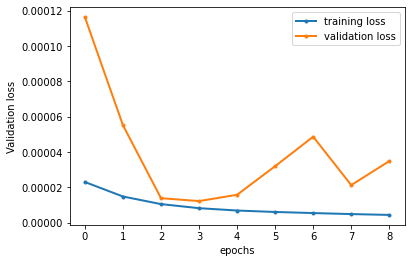

In [28]:
idx0 = 1
plt.figure()
plt.plot(history5.history['loss'][idx0:], '.-', lw=2)
plt.plot(history5.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

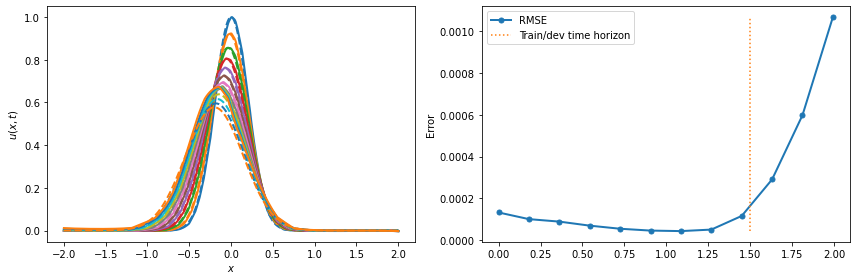

In [29]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,1,2)# reshaping is 
    u_approx = deep_approx5.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

## Finite Volume - Convection equation 1D

In [30]:
x_left = -2
x_right = 2
t_end = 2

D = 0.02
v = 0.1
dx = 0.01
dt = 0.001

cfl = D*dt/dx**2
print('CFL = %.4f'%(cfl))
x_steps = int((x_right - x_left)/dx)
t_steps = int(t_end/dt)

xx = np.linspace(x_left, x_right, x_steps)
tt = np.linspace(0, t_end, t_steps)
uu = np.zeros((t_steps, x_steps))

CFL = 0.2000


In [31]:
# ICs
def gaussian(x, mu, sig, shift):
    return shift + np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

ic_mean = 0
ic_std = 0.2
ic_shift = 0
uu[0, :] = gaussian(xx, ic_mean, ic_std, ic_shift)

In [32]:
t = 0;
v = 0.1; #setting flux velocity, could be negative
# Solve
inputs = []
outputs = []
for ti, t in enumerate(tt[:-1]):
    for xi, x in enumerate(xx[1:-1]):
        
        Flux_plus = 0.5* v* (uu[ti, xi+1]+uu[ti, xi]) - 0.5 * abs(v)*(uu[ti, xi+1]-uu[ti, xi])
        
        Flux_minus = 0.5* v* (uu[ti, xi]+uu[ti, xi-1]) - 0.5 * abs(v)*(uu[ti, xi]-uu[ti, xi-1])
        
        #this form of the flux is useful if the flux velocity is negative.
        
        uu[ti+1, xi] = uu[ti, xi] - (dt/dx)*(Flux_plus - Flux_minus)
        
        #uu[ti+1, xi] = adv_diff_euler_step(uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1], D, v, dx, dt)

        # zero flux BC
        uu[ti+1, 0] = uu[ti+1, 1]
        uu[ti+1, -1] = uu[ti+1, -2]

        # Save data
        inputs.append([t, x])
        outputs.append(uu[ti+1, xi])



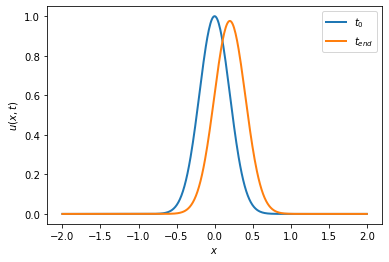

In [33]:
fig = plt.figure()
plt.plot(xx, uu[0, :], lw=2)
plt.plot(xx, uu[-1, :], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend(['$t_0$', '$t_{end}$'])


plt.show()

## Training a Dense Network

Epoch 1/10
14918/14918 [==============================] - 12s 808us/step - loss: 0.0166 - val_loss: 1.8726e-04
Epoch 2/10
14918/14918 [==============================] - 11s 730us/step - loss: 7.9457e-05 - val_loss: 5.9155e-05
Epoch 3/10
14918/14918 [==============================] - 12s 772us/step - loss: 3.7824e-05 - val_loss: 2.5802e-05
Epoch 4/10
14918/14918 [==============================] - 11s 705us/step - loss: 1.4261e-05 - val_loss: 1.8717e-05
Epoch 5/10
14918/14918 [==============================] - 10s 684us/step - loss: 9.0370e-06 - val_loss: 9.7657e-06
Epoch 6/10
14918/14918 [==============================] - 12s 798us/step - loss: 7.4988e-06 - val_loss: 1.0561e-05
Epoch 7/10
14918/14918 [==============================] - 11s 741us/step - loss: 6.8846e-06 - val_loss: 3.6871e-06
Epoch 8/10
14918/14918 [==============================] - 11s 712us/step - loss: 6.3708e-06 - val_loss: 4.3204e-06
Epoch 9/10
14918/14918 [==============================] - 11s 719us/step - loss: 5.9

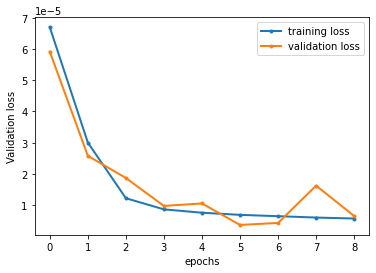

In [34]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

# Build model
deep_approx6 = keras.models.Sequential()
deep_approx6.add(layers.Dense(10, input_dim=2, activation='elu'))
deep_approx6.add(layers.Dense(10, activation='elu'))
deep_approx6.add(layers.Dense(1, activation='linear'))

# Compile model
deep_approx6.compile(loss='mse', optimizer='adam')

# Fit!
history6 = deep_approx6.fit(X_train, y_train,
            epochs=10, batch_size=32,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

deep_approx6.summary()

# history.history contains loss information

idx0 = 1
plt.figure()
plt.plot(history6.history['loss'][idx0:], '.-', lw=2)
plt.plot(history6.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

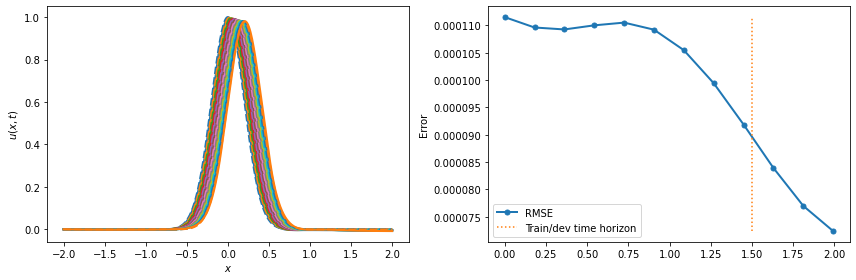

In [35]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx6.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

## CNN

In [36]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

In [37]:
X_train = X_train.reshape(-1,2,1,1)
X_dev = X_dev.reshape(-1,2,1,1)

In [38]:
# We use CNN-1 because it performed better

deep_approx7 = Sequential()
deep_approx7.add(Conv2D(5, kernel_size=(1,1), activation='relu', input_shape=(2,1,1),padding='same'))
deep_approx7.add(Flatten())
deep_approx7.add(layers.Dense(20, activation='relu'))
deep_approx7.add(layers.Dense(1, activation='linear'))

deep_approx7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 1, 5)           10        
_________________________________________________________________
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [39]:
deep_approx7.compile(loss='mse', optimizer='adam')

In [40]:
history7 = deep_approx7.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
95472/95472 [==============================] - 67s 705us/step - loss: 0.0018 - val_loss: 6.1228e-05
Epoch 2/10
95472/95472 [==============================] - 63s 657us/step - loss: 3.9695e-05 - val_loss: 2.5785e-05
Epoch 3/10
95472/95472 [==============================] - 61s 642us/step - loss: 3.1083e-05 - val_loss: 4.3114e-05
Epoch 4/10
95472/95472 [==============================] - 61s 642us/step - loss: 2.7581e-05 - val_loss: 3.6341e-05
Epoch 5/10
95472/95472 [==============================] - 66s 693us/step - loss: 2.7757e-05 - val_loss: 5.3199e-05
Epoch 6/10
95472/95472 [==============================] - 72s 757us/step - loss: 2.6045e-05 - val_loss: 4.3407e-05
Epoch 7/10
95472/95472 [==============================] - 74s 771us/step - loss: 2.5406e-05 - val_loss: 2.9590e-05


In [41]:
X_test = X_test.reshape(-1,2,1,1)

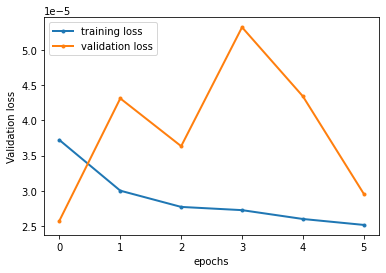

In [42]:
idx0 = 1
plt.figure()
plt.plot(history7.history['loss'][idx0:], '.-', lw=2)
plt.plot(history7.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

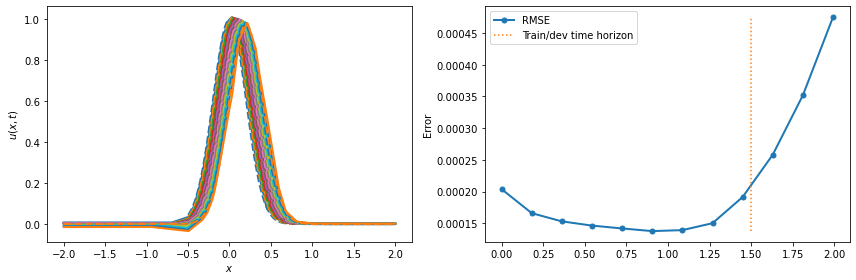

In [43]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,2,1,1)
    u_approx = deep_approx7.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

## LSTM

In [44]:
X_train = X_train.reshape(-1,1,2)
X_dev = X_dev.reshape(-1,1,2)

In [45]:
n_steps = 1
n_features = 2

deep_approx8 = Sequential()
deep_approx8.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
deep_approx8.add(layers.Dense(5, activation='relu'))
deep_approx8.add(layers.Dense(1, activation='linear'))

deep_approx8.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 6         
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


In [46]:
deep_approx8.compile(optimizer='adam', loss='mse')

In [47]:
history8 = deep_approx8.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
95472/95472 [==============================] - 81s 843us/step - loss: 0.0026 - val_loss: 1.3609e-05
Epoch 2/10
95472/95472 [==============================] - 85s 893us/step - loss: 1.8837e-05 - val_loss: 6.5367e-06
Epoch 3/10
95472/95472 [==============================] - 91s 950us/step - loss: 1.3735e-05 - val_loss: 7.5556e-06
Epoch 4/10
95472/95472 [==============================] - 76s 799us/step - loss: 1.0787e-05 - val_loss: 5.6304e-06
Epoch 5/10
95472/95472 [==============================] - 76s 795us/step - loss: 9.7917e-06 - val_loss: 6.2119e-06
Epoch 6/10
95472/95472 [==============================] - 76s 797us/step - loss: 9.3526e-06 - val_loss: 1.1841e-05
Epoch 7/10
95472/95472 [==============================] - 77s 808us/step - loss: 8.2735e-06 - val_loss: 4.5210e-06
Epoch 8/10
95472/95472 [==============================] - 79s 831us/step - loss: 8.0262e-06 - val_loss: 4.0435e-06
Epoch 9/10
95472/95472 [==============================] - 78s 818us/step - loss: 7.1

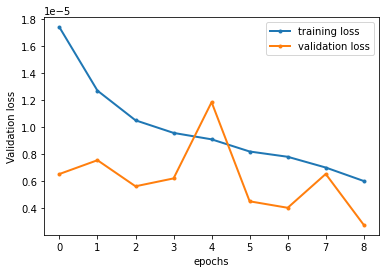

In [48]:
idx0 = 1
plt.figure()
plt.plot(history8.history['loss'][idx0:], '.-', lw=2)
plt.plot(history8.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

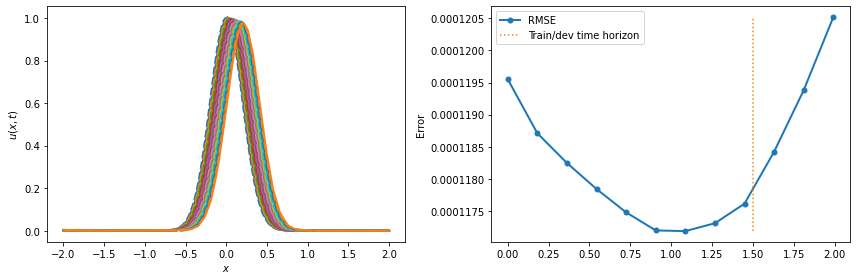

In [49]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,1,2)
    u_approx = deep_approx8.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

### Third order upwind FV scheme

#### We will start with a gaussian initial condition

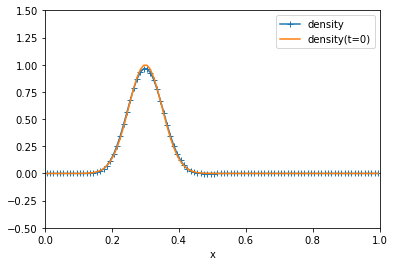

In [4]:
import numpy as np
from matplotlib import pyplot as plt


def set_params():

    global xmin, xmax, c, t_end, nx, cfl, n_ghost

    xmin=0.0
    xmax=1.0
    c = 1.0
    t_end = 1.0

    nx = 100
    cfl = 0.1
    n_ghost = 3

def set_init():

    global time, dx, dt, js, je, nt, x, xb, u, u_init, flux
    time = 0.0
    dx = (xmax-xmin)/(nx)
    dt = cfl*dx/abs(c)

    js = n_ghost
    je = nx + n_ghost

    nt = int(round(t_end/dt))
    if(nt*dt < t_end): nt=nt+1

    x = np.linspace(xmin-(n_ghost-0.5)*dx,xmax+(n_ghost-0.5)*dx,nx+2*n_ghost)
    xb = np.linspace(xmin-(n_ghost-1)*dx,xmax+(n_ghost)*dx,nx+2*n_ghost)

    sigma = 0.05
    u = np.exp(-(x-0.3)**2/(2*sigma**2))

    #for j in range(js,je+1):
    #    if(0.5 < x[j]): u[j] = 0.0
    #    if((0.6 <= x[j]) and (x[j]<=0.8)):
    #        u[j]=1.0
    #    elif(0.8<x[j]):
    #        u[j]=0.0

    apply_bc(u)

    u_init = u.copy()
    flux = np.zeros_like(u)

def apply_bc(u):
    for j in range(0,n_ghost):
        u[je+j]=u[js+j]
        u[j]=u[je-n_ghost+j]

def plot_it():
    plt.plot(x[js:je], u[js:je], "-+",label="density");
    plt.plot(x[js:je], u_init[js:je], label="density(t=0)");
    plt.xlim(0.0,1.0); plt.ylim(-0.5,1.5)
    plt.xlabel("x")
    plt.legend(prop={'size': 10})
    plt.show()

def advance():

    global time, u, t_end, dt, u_old, t_steps, x_steps #added
    
    t_steps = 0 #added
    
    while (time < t_end):
        
        dt1 = min(dt, t_end - time)
        
        u_old = u.copy()
        f_step1(u,dt1)
        f_step1(u,dt1)
        u=3./4.*u_old + 1./4.*u
        f_step1(u,dt1)
        u=1./3.*u_old + 2./3.*u

        time = time + dt1
        
        x_steps = 0
        
        for j in range(js,je+1):            #added 
            inputs.append([time, x[j]])     #added
            outputs.append(u[j])            #added
            uu[t_steps,int(x_steps)] = u[j] #added
            x_steps = x_steps + 1           #added
            
        t_steps = t_steps + 1               #added   

def f_step1(u,dt):

    global xb

    ubL = np.zeros_like(u)
    ubR = np.zeros_like(u)

    ubL[js-1:je] = ((1.0-1.0/6.)*u[js-1:je]
                           -(1./4.-1./12.0)*u[js-1-1:je-1]
                           +(1./4.+1./12.)*u[js-1+1:je+1])

    ubR[js-1:je] = ((1.0-1.0/6.)*u[js-1+1:je+1]
                           -(1./4.-1./12.0)*u[js-1+2:je+2]
                           +(1./4.+1./12.)*u[js-1:je])

    flux_common(flux, ubL, ubR)

    u[js:je] = u[js:je] - dt/dx*(flux[js:je] - flux[js-1:je-1])

    apply_bc(u)
    

def flux_func(ub):
    global c
    return c*ub

def flux_common(flux, ubL, ubR):

    flux_L = flux_func(ubL)
    flux_R = flux_func(ubR)

    flux[js-1:je] = (1/2) * (flux_L[js-1:je] + flux_R[js-1:je]) \
                      - (np.abs(c)/2)*(ubR[js-1:je]-ubL[js-1:je])

set_params()
set_init()

t_steps = int(t_end/dt) #added
x_steps = je-js+1       #added
xx = np.linspace(x[js], x[je+1], int(x_steps)) #added
tt = np.linspace(0, t_end, t_steps)            #added
uu = np.zeros((t_steps, int(x_steps)))         #added
inputs = []    #added
outputs = []   #added


advance()
plot_it()

### DNN

Epoch 1/10
1894/1894 [==============================] - 2s 848us/step - loss: 0.0777 - val_loss: 0.0838
Epoch 2/10
1894/1894 [==============================] - 1s 669us/step - loss: 0.0596 - val_loss: 0.1057
Epoch 3/10
1894/1894 [==============================] - 1s 661us/step - loss: 0.0497 - val_loss: 0.0793
Epoch 4/10
1894/1894 [==============================] - 1s 708us/step - loss: 0.0397 - val_loss: 0.0335
Epoch 5/10
1894/1894 [==============================] - 1s 669us/step - loss: 0.0243 - val_loss: 0.0289
Epoch 6/10
1894/1894 [==============================] - 1s 667us/step - loss: 0.0173 - val_loss: 0.0240
Epoch 7/10
1894/1894 [==============================] - 1s 670us/step - loss: 0.0129 - val_loss: 0.0281
Epoch 8/10
1894/1894 [==============================] - 1s 670us/step - loss: 0.0082 - val_loss: 0.0343
Epoch 9/10
1894/1894 [==============================] - 1s 669us/step - loss: 0.0045 - val_loss: 0.0413
Epoch 10/10
1894/1894 [==============================] - 1s 669u

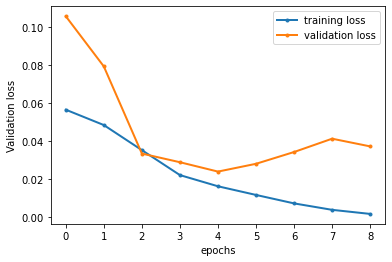

In [7]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(10, input_dim=2, activation='elu'))
deep_approx.add(layers.Dense(10, activation='elu'))
deep_approx.add(layers.Dense(1, activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_approx.fit(X_train, y_train,
            epochs=10, batch_size=32,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

deep_approx.summary()

# history.history contains loss information

idx0 = 1
plt.figure()
plt.plot(history.history['loss'][idx0:], '.-', lw=2)
plt.plot(history.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

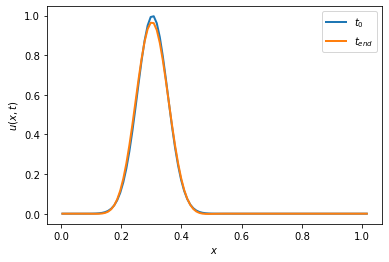

In [8]:
fig = plt.figure()
plt.plot(xx, uu[0, :], lw=2)
plt.plot(xx, uu[-1, :], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend(['$t_0$', '$t_{end}$'])


plt.show()

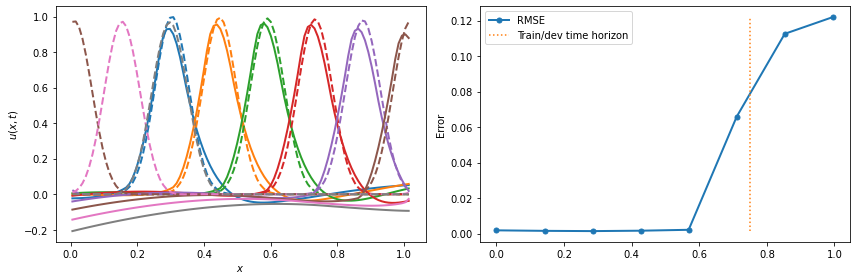

In [11]:
import seaborn as sns
c = sns.color_palette()

nplots = 7
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
#ax0.legend()
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

### CNN

In [15]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D

In [12]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

In [13]:
X_train = X_train.reshape(-1,2,1,1)
X_dev = X_dev.reshape(-1,2,1,1)

In [16]:
deep_approx7 = Sequential()
deep_approx7.add(Conv2D(5, kernel_size=(1,1), activation='relu', input_shape=(2,1,1),padding='same'))
deep_approx7.add(Flatten())
deep_approx7.add(layers.Dense(20, activation='relu'))
deep_approx7.add(layers.Dense(1, activation='linear'))

deep_approx7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 1, 5)           10        
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [17]:
deep_approx7.compile(loss='mse', optimizer='adam')
history7 = deep_approx7.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
12120/12120 [==============================] - 10s 772us/step - loss: 0.0501 - val_loss: 0.0333
Epoch 2/10
12120/12120 [==============================] - 8s 653us/step - loss: 0.0054 - val_loss: 0.0310
Epoch 3/10
12120/12120 [==============================] - 7s 574us/step - loss: 3.0287e-04 - val_loss: 0.0404
Epoch 4/10
12120/12120 [==============================] - 7s 568us/step - loss: 2.1324e-04 - val_loss: 0.0297
Epoch 5/10
12120/12120 [==============================] - 7s 590us/step - loss: 1.8683e-04 - val_loss: 0.0294
Epoch 6/10
12120/12120 [==============================] - 7s 587us/step - loss: 1.8162e-04 - val_loss: 0.0303
Epoch 7/10
12120/12120 [==============================] - 7s 579us/step - loss: 2.0041e-04 - val_loss: 0.0307
Epoch 8/10
12120/12120 [==============================] - 7s 593us/step - loss: 1.7609e-04 - val_loss: 0.0265
Epoch 9/10
12120/12120 [==============================] - 7s 613us/step - loss: 1.7134e-04 - val_loss: 0.0301
Epoch 10/10
12120

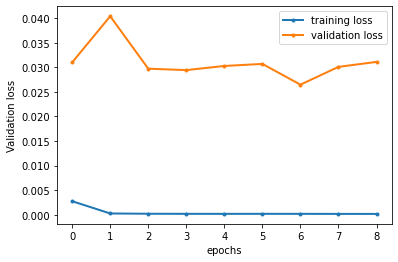

In [18]:
idx0 = 1
plt.figure()
plt.plot(history7.history['loss'][idx0:], '.-', lw=2)
plt.plot(history7.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

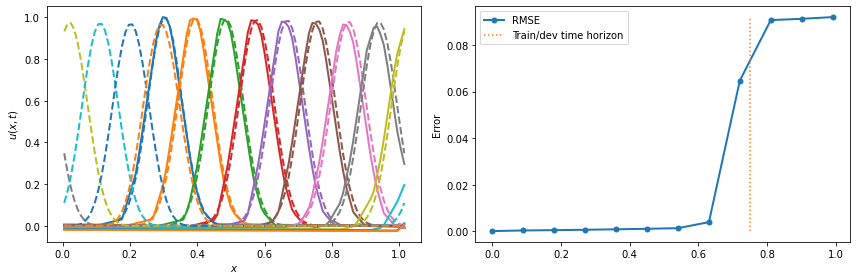

In [19]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,2,1,1)
    u_approx = deep_approx7.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

#### Square wave initial condition

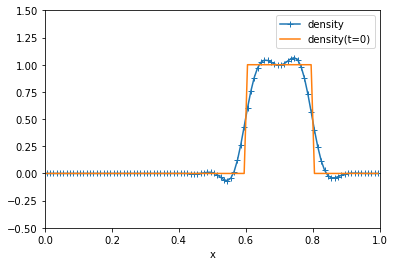

In [22]:
import numpy as np
from matplotlib import pyplot as plt


def set_params():

    global xmin, xmax, c, t_end, nx, cfl, n_ghost

    xmin=0.0
    xmax=1.0
    c = 1.0
    t_end = 1.0

    nx = 100
    cfl = 0.1
    n_ghost = 3

def set_init():

    global time, dx, dt, js, je, nt, x, xb, u, u_init, flux
    time = 0.0
    dx = (xmax-xmin)/(nx)
    dt = cfl*dx/abs(c)

    js = n_ghost
    je = nx + n_ghost

    nt = int(round(t_end/dt))
    if(nt*dt < t_end): nt=nt+1

    x = np.linspace(xmin-(n_ghost-0.5)*dx,xmax+(n_ghost-0.5)*dx,nx+2*n_ghost)
    xb = np.linspace(xmin-(n_ghost-1)*dx,xmax+(n_ghost)*dx,nx+2*n_ghost)

    sigma = 0.05
    u = 0.0*np.exp(-(x-0.3)**2/(2*sigma**2))

    for j in range(js,je+1):
        if(0.5 < x[j]): u[j] = 0.0
        if((0.6 <= x[j]) and (x[j]<=0.8)):
            u[j]=1.0
        elif(0.8<x[j]):
            u[j]=0.0

    apply_bc(u)

    u_init = u.copy()
    flux = np.zeros_like(u)

def apply_bc(u):
    for j in range(0,n_ghost):
        u[je+j]=u[js+j]
        u[j]=u[je-n_ghost+j]

def plot_it():
    plt.plot(x[js:je], u[js:je], "-+",label="density");
    plt.plot(x[js:je], u_init[js:je], label="density(t=0)");
    plt.xlim(0.0,1.0); plt.ylim(-0.5,1.5)
    plt.xlabel("x")
    plt.legend(prop={'size': 10})
    plt.show()

def advance():

    global time, u, t_end, dt, u_old, t_steps, x_steps #added
    
    t_steps = 0 #added
    
    while (time < t_end):
        
        dt1 = min(dt, t_end - time)
        
        u_old = u.copy()
        f_step1(u,dt1)
        f_step1(u,dt1)
        u=3./4.*u_old + 1./4.*u
        f_step1(u,dt1)
        u=1./3.*u_old + 2./3.*u

        time = time + dt1
        
        x_steps = 0
        
        for j in range(js,je+1):            #added 
            inputs.append([time, x[j]])     #added
            outputs.append(u[j])            #added
            uu[t_steps,int(x_steps)] = u[j] #added
            x_steps = x_steps + 1           #added
            
        t_steps = t_steps + 1               #added   

def f_step1(u,dt):

    global xb

    ubL = np.zeros_like(u)
    ubR = np.zeros_like(u)

    ubL[js-1:je] = ((1.0-1.0/6.)*u[js-1:je]
                           -(1./4.-1./12.0)*u[js-1-1:je-1]
                           +(1./4.+1./12.)*u[js-1+1:je+1])

    ubR[js-1:je] = ((1.0-1.0/6.)*u[js-1+1:je+1]
                           -(1./4.-1./12.0)*u[js-1+2:je+2]
                           +(1./4.+1./12.)*u[js-1:je])

    flux_common(flux, ubL, ubR)

    u[js:je] = u[js:je] - dt/dx*(flux[js:je] - flux[js-1:je-1])

    apply_bc(u)
    

def flux_func(ub):
    global c
    return c*ub

def flux_common(flux, ubL, ubR):

    flux_L = flux_func(ubL)
    flux_R = flux_func(ubR)

    flux[js-1:je] = (1/2) * (flux_L[js-1:je] + flux_R[js-1:je]) \
                      - (np.abs(c)/2)*(ubR[js-1:je]-ubL[js-1:je])

set_params()
set_init()

t_steps = int(t_end/dt) #added
x_steps = je-js+1       #added
xx = np.linspace(x[js], x[je+1], int(x_steps)) #added
tt = np.linspace(0, t_end, t_steps)            #added
uu = np.zeros((t_steps, int(x_steps)))         #added
inputs = []    #added
outputs = []   #added


advance()
plot_it()

### DNN

Epoch 1/10
1894/1894 [==============================] - 2s 799us/step - loss: 0.1200 - val_loss: 0.2037
Epoch 2/10
1894/1894 [==============================] - 1s 737us/step - loss: 0.0823 - val_loss: 0.1229
Epoch 3/10
1894/1894 [==============================] - 1s 743us/step - loss: 0.0288 - val_loss: 0.0800
Epoch 4/10
1894/1894 [==============================] - 1s 743us/step - loss: 0.0140 - val_loss: 0.0506
Epoch 5/10
1894/1894 [==============================] - 1s 754us/step - loss: 0.0121 - val_loss: 0.0498
Epoch 6/10
1894/1894 [==============================] - 2s 896us/step - loss: 0.0110 - val_loss: 0.0175
Epoch 7/10
1894/1894 [==============================] - 1s 751us/step - loss: 0.0091 - val_loss: 0.0162
Epoch 8/10
1894/1894 [==============================] - 1s 746us/step - loss: 0.0070 - val_loss: 0.0080
Epoch 9/10
1894/1894 [==============================] - 1s 754us/step - loss: 0.0053 - val_loss: 0.0064
Epoch 10/10
1894/1894 [==============================] - 1s 753u

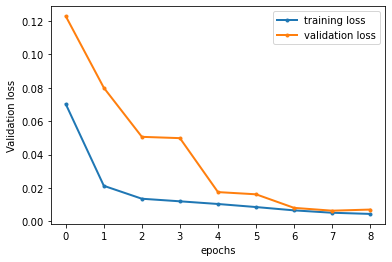

In [47]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(50, input_dim=2, activation='elu'))
deep_approx.add(layers.Dense(30, activation='elu'))
deep_approx.add(layers.Dense(20, activation='elu'))
deep_approx.add(layers.Dense(1, activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_approx.fit(X_train, y_train,
            epochs=10, batch_size=32,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

deep_approx.summary()

# history.history contains loss information

idx0 = 1
plt.figure()
plt.plot(history.history['loss'][idx0:], '.-', lw=2)
plt.plot(history.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

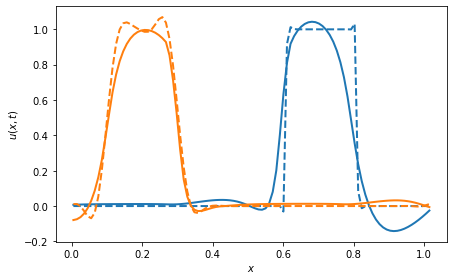

In [51]:
import seaborn as sns
c = sns.color_palette()

nplots = 2
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)

for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
#ax0.legend()
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

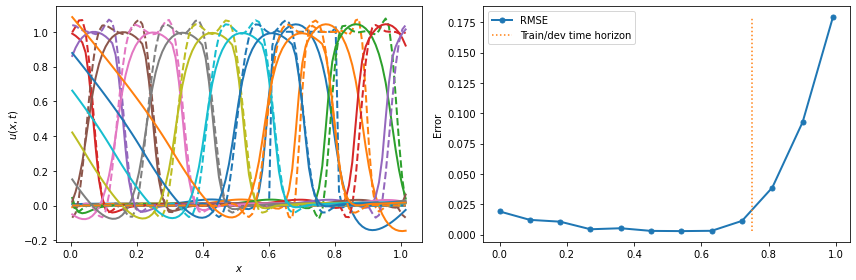

In [49]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
#ax0.legend()
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

### CNN

In [52]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

X_train = X_train.reshape(-1,2,1,1)
X_dev = X_dev.reshape(-1,2,1,1)

In [58]:
deep_approx7 = Sequential()
deep_approx7.add(Conv2D(5, kernel_size=(1,1), activation='relu', input_shape=(2,1,1),padding='same'))
deep_approx7.add(Flatten())
deep_approx7.add(layers.Dense(30, activation='relu'))
deep_approx7.add(layers.Dense(20, activation='relu'))
deep_approx7.add(layers.Dense(1, activation='linear'))

deep_approx7.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 1, 5)           10        
_________________________________________________________________
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_35 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 21        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [59]:
deep_approx7.compile(loss='mse', optimizer='adam')
history7 = deep_approx7.fit(X_train, y_train,
            epochs=10, batch_size=5,
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
12120/12120 [==============================] - 10s 786us/step - loss: 0.0708 - val_loss: 0.0439
Epoch 2/10
12120/12120 [==============================] - 9s 784us/step - loss: 0.0080 - val_loss: 0.0204
Epoch 3/10
12120/12120 [==============================] - 10s 803us/step - loss: 0.0063 - val_loss: 0.0077
Epoch 4/10
12120/12120 [==============================] - 10s 808us/step - loss: 0.0055 - val_loss: 0.0012
Epoch 5/10
12120/12120 [==============================] - 10s 817us/step - loss: 0.0036 - val_loss: 6.9428e-04
Epoch 6/10
12120/12120 [==============================] - 10s 817us/step - loss: 0.0021 - val_loss: 8.1741e-04
Epoch 7/10
12120/12120 [==============================] - 10s 823us/step - loss: 0.0016 - val_loss: 0.0163
Epoch 8/10
12120/12120 [==============================] - 10s 821us/step - loss: 0.0013 - val_loss: 8.2211e-04
Epoch 9/10
12120/12120 [==============================] - 10s 821us/step - loss: 0.0017 - val_loss: 9.1647e-04
Epoch 10/10
12120/1212

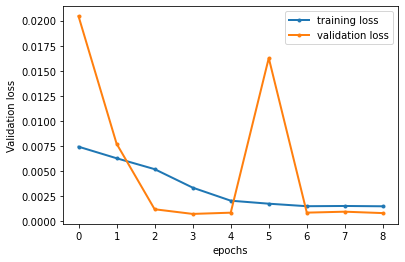

In [60]:
idx0 = 1
plt.figure()
plt.plot(history7.history['loss'][idx0:], '.-', lw=2)
plt.plot(history7.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

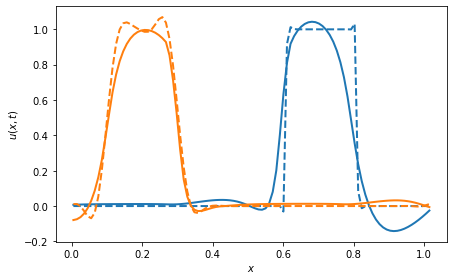

In [61]:
import seaborn as sns
c = sns.color_palette()

nplots = 2
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)

for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
#ax0.legend()
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

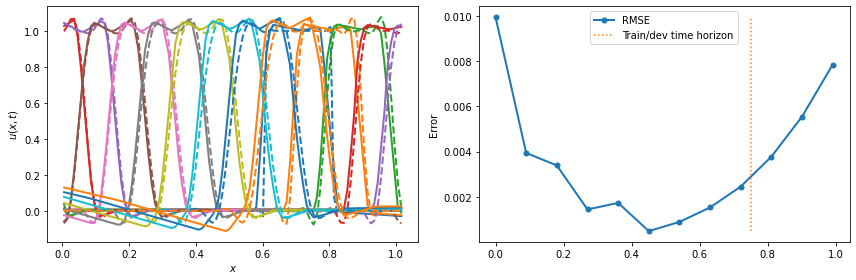

In [62]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    data_in = data_in.reshape(-1,2,1,1)
    u_approx = deep_approx7.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()